In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader, TensorDataset
import math
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import importlib
import modules
import modules.comp.nn_based
importlib.reload(modules.comp.nn_based)
from modules.comp.nn_based import *
from sklearn.model_selection import train_test_split

In [11]:
from modules.utils.noise_create import create_1d_data

In [3]:
batch_size = 32
num_epochs = 20
train_split = 0.8

In [4]:
def plot_results(noisy, clean, denoised, title=""):
    """
    Plot a few examples comparing the noisy input, clean signal, and denoised output.
    """
    num_examples = 3
    plt.figure(figsize=(8, 4))
    for i in range(num_examples):
        plt.subplot(num_examples, 1, i+1)
        plt.plot(clean[i].squeeze().cpu().numpy(), label="Clean Signal", linewidth=2)
        plt.plot(noisy[i].squeeze().cpu().numpy(), label="Noisy Signal", alpha=0.5)
        plt.plot(denoised[i].squeeze().cpu().detach().numpy(), label="Denoised Output", linestyle="--")
        plt.legend(loc="upper right")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

##### 1D Noisy Signal Generation 
Observation = Sine Wave + Noise ~ N(0, 1)

(10000, 100) (10000, 100) (10000, 100)


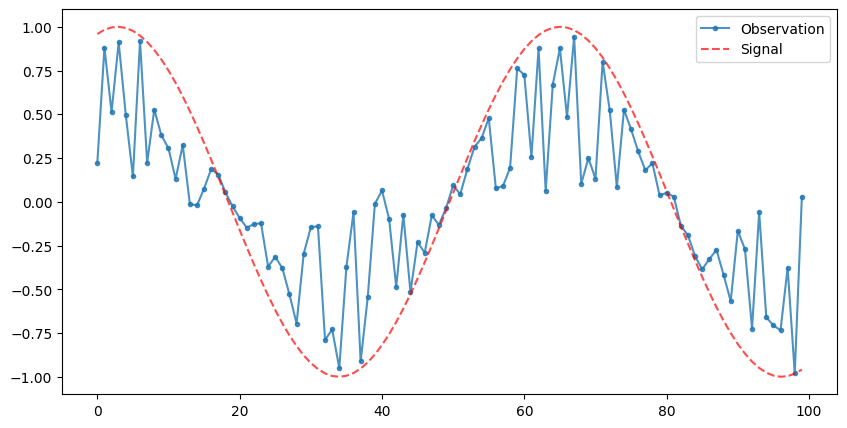

In [12]:
n_samples = 10000
rn = random.randint(0, n_samples)

observation, signal, noise = create_1d_data(n_samples=n_samples)
print(observation.shape, signal.shape, noise.shape)

plt.figure(figsize=(10, 5))

plt.plot(observation[rn], label="Observation", alpha=0.8, marker='.')
plt.plot(signal[rn], label="Signal", linestyle="dashed", alpha=0.7, color = 'red')
plt.legend()
plt.show()


In [6]:
observation_train, observation_val, signal_train, signal_val = train_test_split(observation, signal, test_size = 1 - train_split, random_state=28)

print('Shape: ', observation_train.shape, signal_train.shape, observation_val.shape, signal_val.shape)

observation_train = torch.tensor(observation_train, dtype=torch.float32)
signal_train = torch.tensor(signal_train, dtype=torch.float32)
observation_val = torch.tensor(observation_val, dtype=torch.float32)
signal_val = torch.tensor(signal_val, dtype=torch.float32)

dataset_train = TensorDataset(observation_train, signal_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(observation_val, signal_val)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

print(train_loader, val_loader)

Shape:  (8000, 100) (8000, 100) (2000, 100) (2000, 100)
<torch.utils.data.dataloader.DataLoader object at 0x000002235DF81550> <torch.utils.data.dataloader.DataLoader object at 0x0000022316B411F0>


#### Denoising Autoencoder (DAE)

Training Denoising Autoencoder (DAE)...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 100]              64
              ReLU-2              [-1, 16, 100]               0
         AvgPool1d-3               [-1, 16, 50]               0
            Conv1d-4                [-1, 8, 50]             392
              ReLU-5                [-1, 8, 50]               0
         AvgPool1d-6                [-1, 8, 25]               0
            Conv1d-7                [-1, 8, 25]             200
              ReLU-8                [-1, 8, 25]               0
          Upsample-9                [-1, 8, 50]               0
           Conv1d-10               [-1, 16, 50]             400
             ReLU-11               [-1, 16, 50]               0
         Upsample-12              [-1, 16, 100]               0
           Conv1d-13               [-1, 1, 100]              49

Epoch [1/20] Train Loss: 0.0954 | Val Loss: 0.0089


Epoch [2/20] Train Loss: 0.0068 | Val Loss: 0.0055


Epoch [3/20] Train Loss: 0.0049 | Val Loss: 0.0047


Epoch [4/20] Train Loss: 0.0040 | Val Loss: 0.0036


Epoch [5/20] Train Loss: 0.0034 | Val Loss: 0.0031


Epoch [6/20] Train Loss: 0.0030 | Val Loss: 0.0029


Epoch [7/20] Train Loss: 0.0029 | Val Loss: 0.0027


Epoch [8/20] Train Loss: 0.0027 | Val Loss: 0.0026


Epoch [9/20] Train Loss: 0.0026 | Val Loss: 0.0026


Epoch [10/20] Train Loss: 0.0025 | Val Loss: 0.0025


Epoch [11/20] Train Loss: 0.0025 | Val Loss: 0.0027


Epoch [12/20] Train Loss: 0.0025 | Val Loss: 0.0023


Epoch [13/20] Train Loss: 0.0024 | Val Loss: 0.0028


Epoch [14/20] Train Loss: 0.0024 | Val Loss: 0.0027


Epoch [15/20] Train Loss: 0.0024 | Val Loss: 0.0022


Epoch [16/20] Train Loss: 0.0023 | Val Loss: 0.0022


Epoch [17/20] Train Loss: 0.0023 | Val Loss: 0.0022


Epoch [18/20] Train Loss: 0.0023 | Val Loss: 0.0022


Epoch [19/20] Train Loss: 0.0022 | Val Loss: 0.0022


Epoch [20/20] Train Loss: 0.0022 | Val Loss: 0.0022


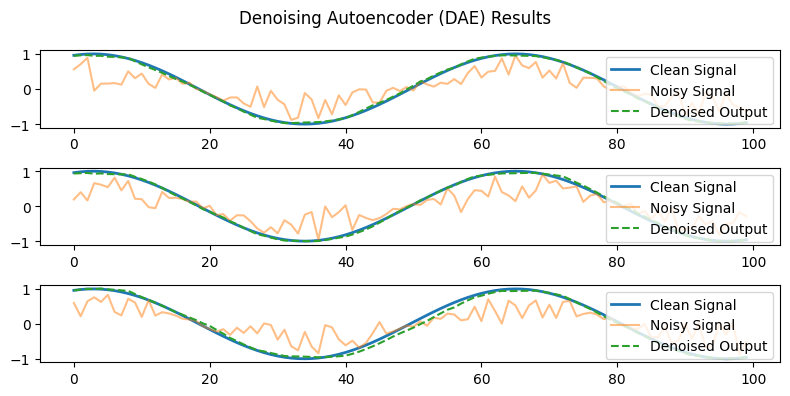

In [7]:
# ----- Denoising Autoencoder (DAE) -----

print("Training Denoising Autoencoder (DAE)...")
dae = DenoisingAutoencoder()
dae.summary()

dae, train_loss, val_loss = train_model(dae, train_loader=train_loader, val_loader=val_loader, num_epochs=num_epochs, return_loss=True)

# Evaluate DAE on a few examples
dae.eval()
device = next(dae.parameters()).device

with torch.no_grad():
    sample_noisy = observation_val[:3].to(device)
    sample_noisy = sample_noisy.reshape(sample_noisy.shape[0], 1, -1)
    dae_output = dae(sample_noisy)

plot_results(observation_val, signal_val, dae_output, title="Denoising Autoencoder (DAE) Results")

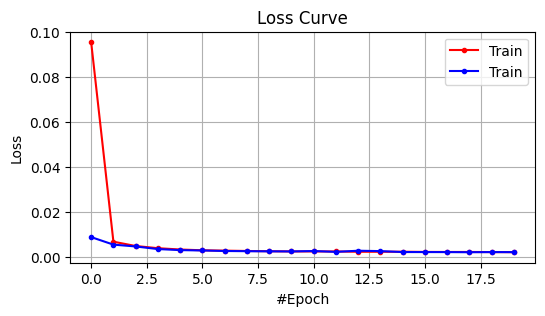

In [8]:
fig = plt.figure(figsize = (6, 3))

plt.plot(range(0, num_epochs), train_loss, label = 'Train', color = 'red', marker = '.')
plt.plot(range(0, num_epochs), val_loss, label = 'Train', color = 'blue', marker = '.')
plt.xlabel('#Epoch')
plt.ylabel('Loss')

plt.title('Loss Curve')

plt.legend()
plt.grid()
plt.show()

#### CNN - Based Denoising 

Training Basic CNN for Denoising...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 100]             128
              Tanh-2              [-1, 32, 100]               0
            Conv1d-3              [-1, 64, 100]           6,208
              Tanh-4              [-1, 64, 100]               0
            Conv1d-5              [-1, 64, 100]          12,352
              Tanh-6              [-1, 64, 100]               0
            Conv1d-7              [-1, 32, 100]           6,176
              Tanh-8              [-1, 32, 100]               0
            Conv1d-9               [-1, 1, 100]              97
Total params: 24,961
Trainable params: 24,961
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.10
Estimated Total Size (MB): 0.39
---------

Epoch [1/20] Train Loss: 0.0247 | Val Loss: 0.0118


Epoch [2/20] Train Loss: 0.0113 | Val Loss: 0.0105


Epoch [3/20] Train Loss: 0.0095 | Val Loss: 0.0088


Epoch [4/20] Train Loss: 0.0084 | Val Loss: 0.0077


Epoch [5/20] Train Loss: 0.0077 | Val Loss: 0.0075


Epoch [6/20] Train Loss: 0.0071 | Val Loss: 0.0067


Epoch [7/20] Train Loss: 0.0067 | Val Loss: 0.0076


Epoch [8/20] Train Loss: 0.0063 | Val Loss: 0.0059


Epoch [9/20] Train Loss: 0.0060 | Val Loss: 0.0057


Epoch [10/20] Train Loss: 0.0058 | Val Loss: 0.0059


Epoch [11/20] Train Loss: 0.0056 | Val Loss: 0.0056


Epoch [12/20] Train Loss: 0.0053 | Val Loss: 0.0053


Epoch [13/20] Train Loss: 0.0052 | Val Loss: 0.0051


Epoch [14/20] Train Loss: 0.0051 | Val Loss: 0.0050


Epoch [15/20] Train Loss: 0.0049 | Val Loss: 0.0052


Epoch [16/20] Train Loss: 0.0048 | Val Loss: 0.0048


Epoch [17/20] Train Loss: 0.0048 | Val Loss: 0.0048


Epoch [18/20] Train Loss: 0.0046 | Val Loss: 0.0045


Epoch [19/20] Train Loss: 0.0045 | Val Loss: 0.0044


Epoch [20/20] Train Loss: 0.0044 | Val Loss: 0.0043


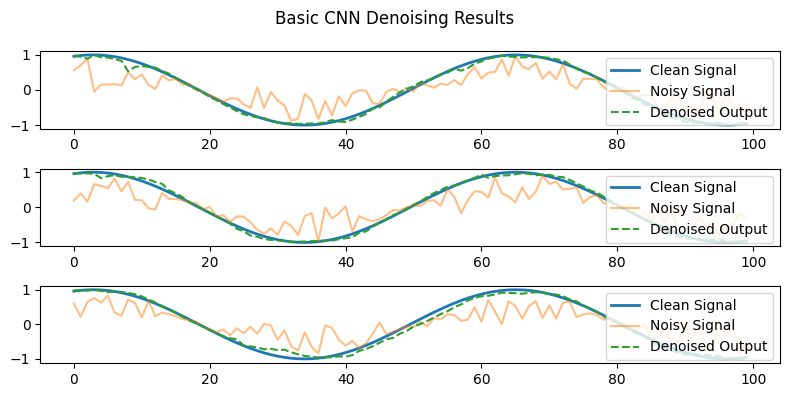

In [9]:
# ----- Basic CNN for Denoising -----

num_epochs = 20

print("Training Basic CNN for Denoising...")
cnn = DenoisingCNN()
cnn.summary()

cnn, train_loss, val_loss = train_model(cnn, train_loader=train_loader, val_loader=val_loader, num_epochs=num_epochs, return_loss=True)

# Evaluate CNN on a few examples
cnn.eval()
device = next(cnn.parameters()).device

with torch.no_grad():
    sample_noisy = observation_val[:3].to(device)
    sample_noisy = sample_noisy.reshape(sample_noisy.shape[0], 1, -1)
    cnn_output = cnn(sample_noisy)

plot_results(observation_val, signal_val, cnn_output, title="Basic CNN Denoising Results")

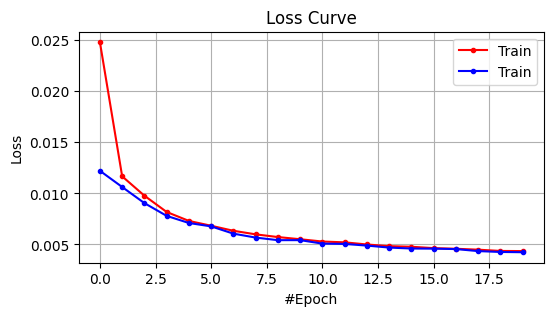

In [15]:
fig = plt.figure(figsize = (6, 3))

plt.plot(range(0, num_epochs), train_loss, label = 'Train', color = 'red', marker = '.')
plt.plot(range(0, num_epochs), val_loss, label = 'Train', color = 'blue', marker = '.')
plt.xlabel('#Epoch')
plt.ylabel('Loss')

plt.title('Loss Curve')

plt.legend()
plt.grid()
plt.show()

#### DDPM Denoising (1d)
The Reverse Diffusion Process is a posterior sampling method conditioned on a noisy image. Here, instead of generating an image by conditioning on isotropic Gaussian noise, it denoises the given noisy image through the reverse process. 

Very Modularized Implementation

```

### We seperately pass a estimation model to the diffusion architechture (for say noise residual estimation) 
model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 32
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 128,
    timesteps = 1000,
    objective = 'pred_v'
)

trainer = Trainer(
    diffusion,
    'path/to/your/images',
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 700000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = True              # whether to calculate fid during training
)

trainer.train()
```

In [ ]:
importlib.reload(unet)
from modules.comp import unet
from modules.comp.diffusion_1d import GaussianDiffusion1D 

In [14]:
print(observation.shape, signal.shape, noise.shape)

(10000, 100) (10000, 100) (10000, 100)


In [ ]:
model = unet.Unet1D(
    dim = 64, ## ? Something is wrong here?
    dim_mults=(1, 2, 4, 8),
    channels=1
)
## time-embedding shape -> t = torch.randint(0, self.num_timesteps, (b,), device=device).long() --> (b, )
t_shape = (1, )
x_shape = (1, 1, 128) ## for some reason the seq_len needs to be 2^n

print(x_shape, t_shape)

model.summary(x_shape=x_shape, t_shape=t_shape)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 128,
    timesteps = 1000,
)


Obtained-Dimensionalities:  [64, 64, 128, 256, 512] [(64, 64), (64, 128), (128, 256), (256, 512)]
(1, 1, 128) (1,)
____________________________________________________________________________________________________
Model: Unet1D
Layer (type)                            Output Shape             Param #        
input_1 (InputLayer)                    (1, 1, 128)              0              
input_2 (InputLayer)                    (1,)                     0              
time_mlp.0 (SinusoidalPosEmb)           (1, 64)                  0              
time_mlp.1 (Linear)                     (1, 256)                 16640          
time_mlp.2 (GELU)                       (1, 256)                 0              
time_mlp.3 (Linear)                     (1, 256)                 65792          
downs.0.0.mlp.0 (SiLU)                  (1, 256)                 0              
downs.0.0.mlp.1 (Linear)                (1, 128)                 32896          
downs.0.0.mlp (Sequential)              (